# Phase 2 Milestone 2

Nama : Raden Mas Xyla Ramadhan

Batch 13

Link Backend 
- https://tfserving-sentiment.herokuapp.com/

Link Frontend 
- https://tfserving-sentiment-fe.herokuapp.com/

Assignment Objectives

Milestones 2 ini dibuat guna mengevaluasi Pembelajaran Phase 2 :

- Mampu memahami konsep NLP.
- Mampu mempersiapkan data untuk digunakan dalam model NLP.
- Mampu menganalisis dan menjelaskan layer yang dibuat.
- Mampu Membuat model klasifikasi sentimen twitter.

## Perkenalan

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import string
import re
import numpy as np
import nltk
from bs4 import BeautifulSoup 
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud
from PIL import Image
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow import math
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, TextVectorization, GRU
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

Download nltk

In [2]:
#download nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
stop_words=nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Xyla\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Xyla\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Xyla\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Xyla\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Menggunakan gpu

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


## Data Loading

In [4]:
#data loading
data = pd.read_csv('twitter_sentiment.csv',header=None)

In [5]:
#read data
data.head()

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Data Cleaning

In [6]:
#check missing value
data.isna().sum()

0      0
1      0
2      0
3    686
dtype: int64

In [7]:
#drop missing value
data.dropna(inplace = True)
data.shape

(73996, 4)

In [8]:
#check data duplicate 
data.duplicated().sum()

2340

In [9]:
#drop duplicate
data.drop_duplicates(subset=None, keep='first', inplace=False)

,0,1,2,3
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
...,...,...,...,...
74677,9200,Nvidia,Positive,Just realized that the Windows partition of my...
74678,9200,Nvidia,Positive,Just realized that my Mac window partition is ...
74679,9200,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,9200,Nvidia,Positive,Just realized between the windows partition of...


In [10]:
#check value counts 
data[2].value_counts()

Negative      22358
Positive      20655
Neutral       18108
Irrelevant    12875
Name: 2, dtype: int64

In [11]:
# deleting the irrelevent reviews because it will help to find the sentiment
data = data[data[2]!='Irrelevant']
data.shape

(61121, 4)

In [12]:
#drop tweet id
data.drop(columns=[0], inplace=True)
data.head()

,1,2,3
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [13]:
sebelum_rename = list(data.columns) # Membuat list dari nama kolom dataframe
sesudah_rename = ['entity','sentiment','tweet'] # Membuat list nama kolom baru untuk dataframe

In [14]:
#rename column
data = data.rename(columns=dict(zip(sebelum_rename, sesudah_rename))) 

In [15]:
#check data
data.head()

,entity,sentiment,tweet
0,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,Borderlands,Positive,I am coming to the borders and I will kill you...
2,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,Borderlands,Positive,im coming on borderlands and i will murder you...
4,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


## Exploratory Data Analysis

### Sentiment

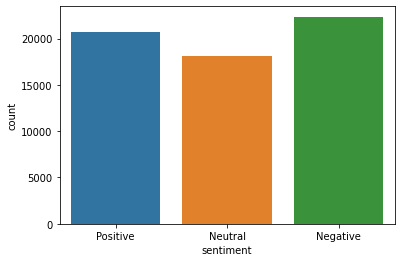

In [16]:
#check sentiment
sns.countplot(data=data, x = 'sentiment');

Insight yang di dapat adalah 
- Negative      22358
- Positive      20655
- Neutral       18108

sentiment yang paling banyak adalah sentiment negative, namun secara overall pesebaran data balance

## Entity vs Sentiment


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31]),
 [Text(0, 0, 'Borderlands'),
  Text(1, 0, 'CallOfDutyBlackopsColdWar'),
  Text(2, 0, 'Amazon'),
  Text(3, 0, 'Overwatch'),
  Text(4, 0, 'Xbox(Xseries)'),
  Text(5, 0, 'NBA2K'),
  Text(6, 0, 'Dota2'),
  Text(7, 0, 'PlayStation5(PS5)'),
  Text(8, 0, 'WorldOfCraft'),
  Text(9, 0, 'CS-GO'),
  Text(10, 0, 'Google'),
  Text(11, 0, 'AssassinsCreed'),
  Text(12, 0, 'ApexLegends'),
  Text(13, 0, 'LeagueOfLegends'),
  Text(14, 0, 'Fortnite'),
  Text(15, 0, 'Microsoft'),
  Text(16, 0, 'Hearthstone'),
  Text(17, 0, 'Battlefield'),
  Text(18, 0, 'PlayerUnknownsBattlegrounds(PUBG)'),
  Text(19, 0, 'Verizon'),
  Text(20, 0, 'HomeDepot'),
  Text(21, 0, 'FIFA'),
  Text(22, 0, 'RedDeadRedemption(RDR)'),
  Text(23, 0, 'CallOfDuty'),
  Text(24, 0, 'TomClancysRainbowSix'),
  Text(25, 0, 'Facebook'),
  Text(26, 0, 'GrandTheftAuto(GTA)'),
  Text(27, 0, 'MaddenNFL')

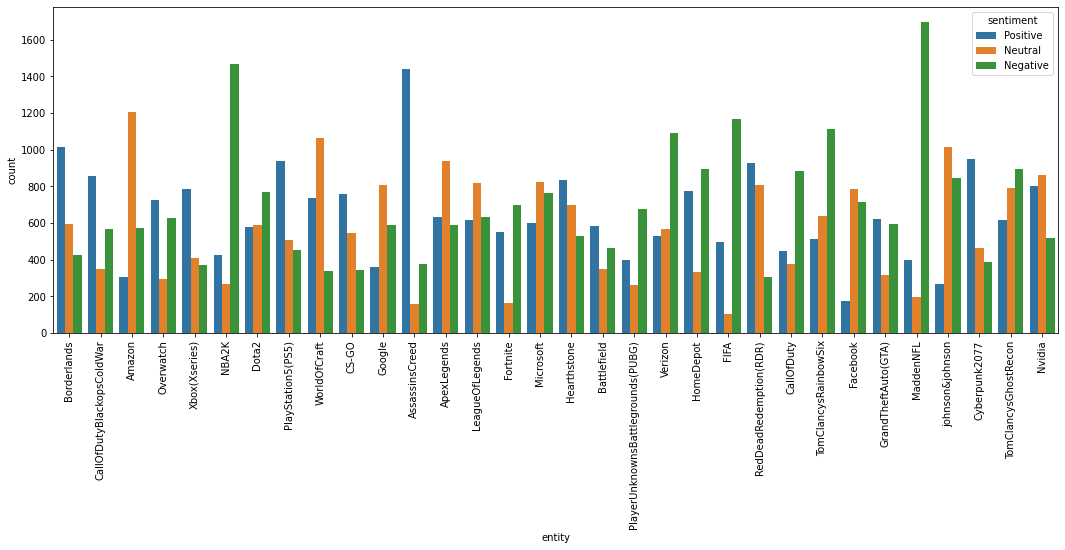

In [17]:
#entity vs sentiment
fig, ax= plt.subplots(figsize=[18,6])
sns.countplot(data=data, hue = 'sentiment', x='entity' )
plt.xticks(rotation=90)

Insight yang di dapat adalah 
- Presentase Sentinment Twitter Positive terbanyak adalah Borderlands, Call Of duty blackops, Overwatch, Playstation 5, Assassins Creed, Heartstone, Battlefield, Red Dead Redemption, GTA, CyberPunk 2077

- Presentase Sentinment Twitter Netral terbanyak adalah Amazon, World of Warcraft, Apex Legends, Microsoft, Facebook, Johnson, and johnson, Nvidia

- Presentase Sentinment Twitter Negative terbanyak adalah NBA 2K, DOTA2, Verizon, FIFA, Madden NFL

bisa disimpulkan bahwa 
- Game Action seperti dan Open World memiliki sentiment positive
- Company seperti Facebook, Amazom memiliki sentiment netral
- Game Sport seperti NBA, FIFA, Madden NFL memilii sentiment negative


### Length Word vs Sentiment

<AxesSubplot:xlabel='length-tweet', ylabel='Count'>

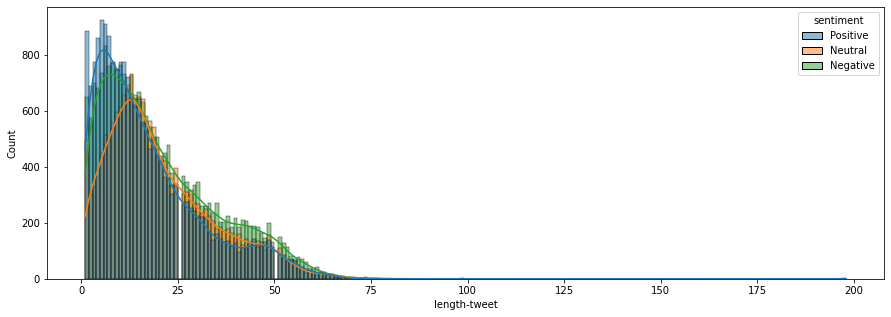

In [18]:
data['length-tweet']=data['tweet'].str.count(' ') + 1
fig, ax=plt.subplots(figsize=[15,5])
sns.histplot(data=data, x = 'length-tweet', hue='sentiment', kde=True, ax=ax)

Insight yang didapat
- Sentiment positive relatif memiliki kata yang sedikit
- Sentiment negative relatif memiliki kata yang panjang karena berupa kritik
- Sentiment Netral ada di tengah tengah antara negative dan positive

## Popular Words

In [20]:
def preprocessing_text(texts):
  texts = texts.lower() #membuat menjadi huruf kecil
  texts = re.sub("@[a-z0-9_.]+"," ", texts) # menghilangkan kata yang berawalan @
  texts = re.sub(r"http\S+", " ", texts) #menghapus link
  texts = re.sub(r"https\S+", " ", texts) #menghapus link
  texts = re.sub(r"www.\S+", " ", texts) #menghapus link
  tokens = word_tokenize(texts) # tokenize
  texts = ' '.join([word for word in tokens if word not in stop_words]) #menghapus stop word
  texts = re.sub(r"#", "", texts)
  return texts

In [21]:
data['tweet-clean']=data['tweet'].apply(lambda x: preprocessing_text(x)) #proses cleaning word

In [22]:
vectorize=TfidfVectorizer() #TFIDF initializer

In [23]:
# membuat fungsi untuk membuat word cloud melalui tf idf.
def plot_word(data, color = 'black', figsize=(15, 10), max_words=50):
    texts1=vectorize.fit_transform(data)
    feature_names = vectorize.get_feature_names()
    dense = texts1.todense()
    lst1 = dense.tolist()
    df = pd.DataFrame(lst1, columns=feature_names)
    wordcloud = WordCloud(stopwords=stop_words, # delete stopword
                      background_color=color,
                      width=1200,
                      height=800,
                      mask = np.array(Image.open("twitter-image.png")),
                      max_words=max_words,
                     ).generate_from_frequencies(df.T.sum(axis=1))
    plt.figure(1,figsize=figsize)
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

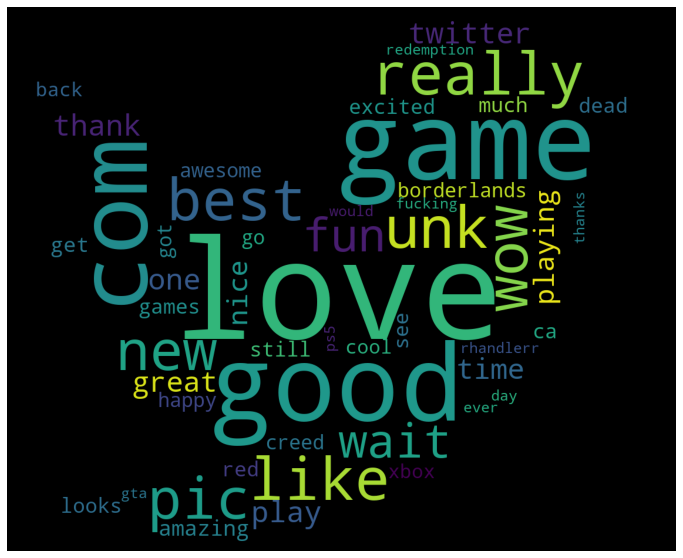

In [24]:
#menampilkan wordcloud sentimen positif
plot_word(data[data.sentiment=="Positive"]['tweet-clean'], max_words=50)

Kata Positive paling banyak adalah : Love, Good dan Like

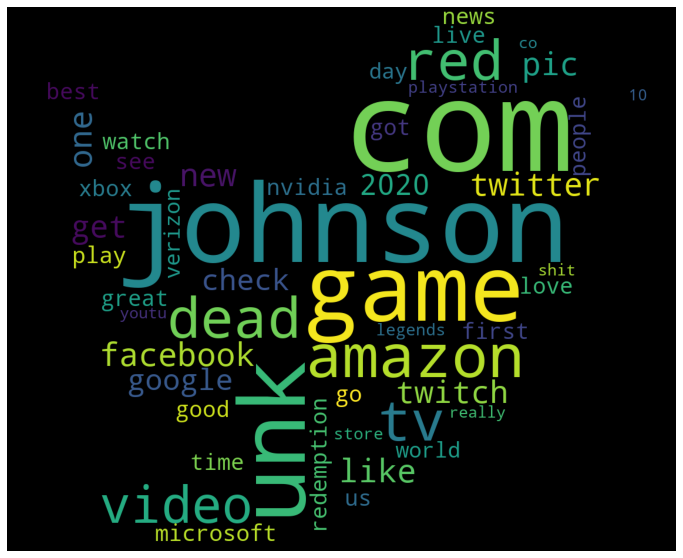

In [25]:
plot_word(data[data.sentiment=="Neutral"]['tweet-clean'], max_words=50)

Kata Netral paling banyak adalah nama perusahaan seperti : Johnson,Facebook,Google,Twitch, 

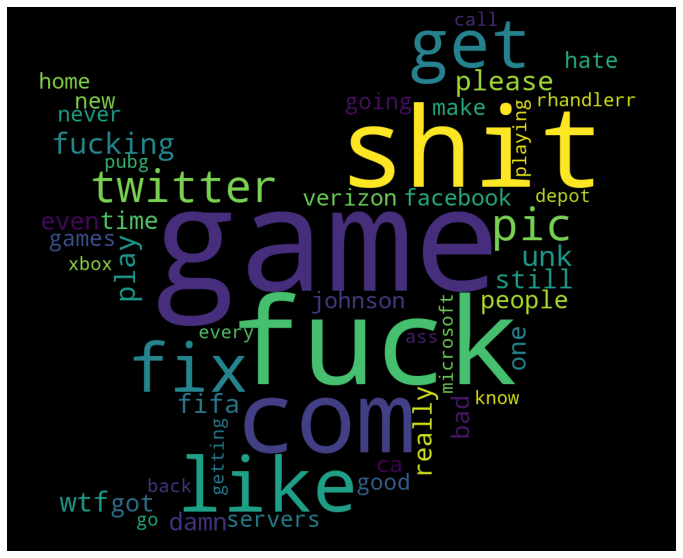

In [26]:
plot_word(data[data.sentiment=="Negative"]['tweet-clean'], max_words=50)

bedasarkan EDA di atas karena rata rata twitter tentang Entity adalah Game maka Game masuk ke kata negative sentiment, 

dan yang sudah pasti negative ada 'fuck' dan 'shit'

## Data Preprocessing

### Data Selection

In [27]:
#remove unwanted data
data=data[['sentiment','tweet']]

In [28]:
#check data
data.head()

,sentiment,tweet
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...


### Get Inference

In [29]:
#Get Data for Model Inference
data_inf = data.sample(10, random_state=63)
data_inf

,sentiment,tweet
3331,Negative,"I used to love Black Ops, but after Modern War..."
65497,Negative,But they will vigorously defend their product ...
17362,Negative,it Fucks wit it
5261,Neutral,Amazon Online – Cherry Natural Tea Chunky Sals...
64078,Negative,How the very hell don't you decipher between a...
35116,Neutral,"But By sometimes forcing Bing on Chrome users,..."
28197,Negative,I would get genuinely upset
6613,Neutral,Join me Neil Neale for my SUPERJAM XTRA SHOW!....
69834,Positive,That's cool. 19. November for the rest of the ...
58408,Positive,I miss Facebook so much a unblockkkk gets me o...


In [30]:
#Remove Inference Set
data_train_test = data.drop(data_inf.index)
data_train_test

,sentiment,tweet
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
74677,Positive,Just realized that the Windows partition of my...
74678,Positive,Just realized that my Mac window partition is ...
74679,Positive,Just realized the windows partition of my Mac ...
74680,Positive,Just realized between the windows partition of...


In [31]:
#Reset Index
data_train_test.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)
data_train_test

,sentiment,tweet
0,Positive,im getting on borderlands and i will murder yo...
1,Positive,I am coming to the borders and I will kill you...
2,Positive,im getting on borderlands and i will kill you ...
3,Positive,im coming on borderlands and i will murder you...
4,Positive,im getting on borderlands 2 and i will murder ...
...,...,...
61106,Positive,Just realized that the Windows partition of my...
61107,Positive,Just realized that my Mac window partition is ...
61108,Positive,Just realized the windows partition of my Mac ...
61109,Positive,Just realized between the windows partition of...


### Case Folding

In [32]:

# removing not and no from stop words as we need them for our model training
stopwords = stopwords.words("english")
stopwords.remove('not')
stopwords.remove('no')

# intializing method for lemmatizing words
lemmatizer = WordNetLemmatizer()

# now creating funtion to clean our data
def cleaned_review(review):
    # remove any html tags
    new_review = BeautifulSoup(review).get_text()
    
    # remove urls from reviews
    no_urls = new_review.replace('http\S+', '').replace('www\S+', '')
    
    # remove any non-letters
    clean_review = re.sub("[^a-zA-Z]", " ", no_urls)
    
    # convert whole sentence to lowercase and split
    new_words = clean_review.lower().split()
    
    # converting stopwords list to set for faster search
    stops = set(stopwords)
    
    # using stopwords to remove irrelavent words and lemmatizing the final output
    final_words = [lemmatizer.lemmatize(word) for word in new_words if not word in stops]
    
    # return the final result
    return (" ".join(final_words))

In [33]:
# now we will use our funtion to get cleaned data and no. of words
data_train_test['tweet-cleaned'] = data_train_test['tweet'].apply(lambda x:cleaned_review(x))

c:\Users\Xyla\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [34]:
# comparing cleaned data with original data
print(data_train_test.iloc[1000,1])
print(data_train_test.iloc[1000,2])

Eli Whitney Roth International is making a movie based loosely on using the game,.. bit. ly / on 2wv4KHM
eli whitney roth international making movie based loosely using game bit ly wv khm


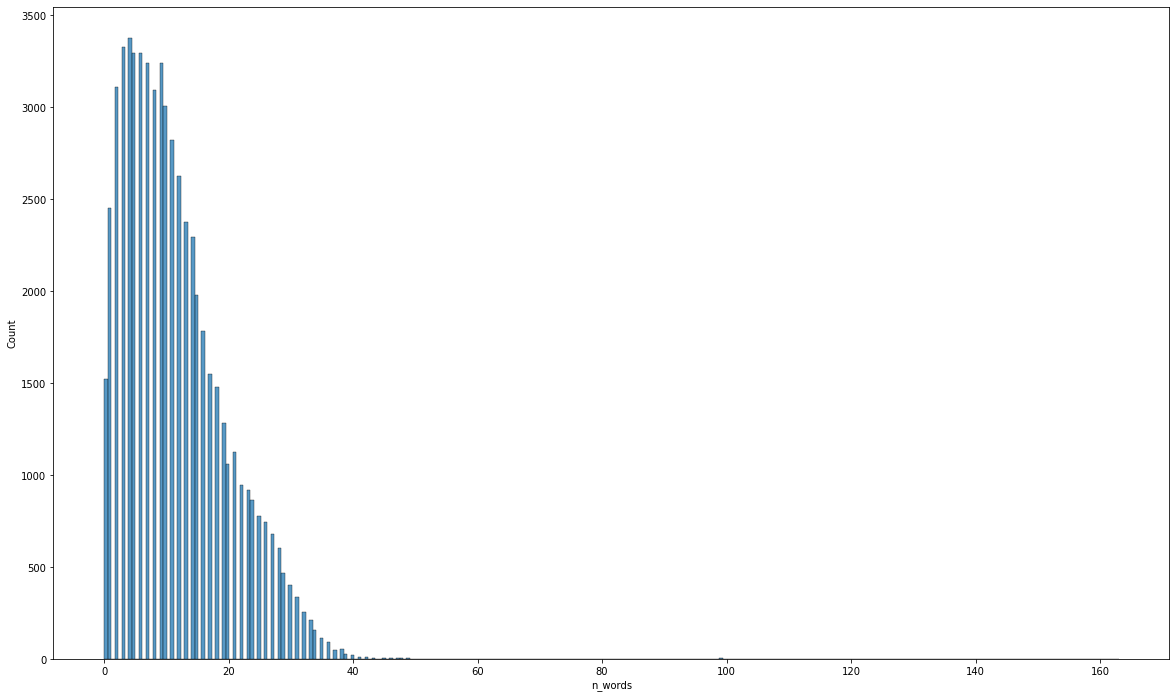

In [35]:
fig, ax = plt.subplots(figsize=(20, 12))
# finding ideal length to use for further process
data_train_test['n_words'] = data_train_test['tweet-cleaned'].apply(lambda x:len(x.split()))
sns.histplot(data = data_train_test, x='n_words')
plt.show()

In [36]:
# so we see above that max no.of words in each sentence is 40
max_len = 40

In [37]:
# now we will tokenize the words to sequence so that our model can understand
# we will also pad the sentences with less than 40 words to make size of each sentence equal
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_train_test['tweet-cleaned'].values)
sequences = tokenizer.texts_to_sequences(data_train_test['tweet-cleaned'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))


Found 23092 unique tokens.


In [38]:
#define x
X = pad_sequences(sequences, maxlen=max_len, padding='post')

In [39]:
#define y
y = data_train_test[['sentiment']]

In [40]:
#replace the sentiment with number
y['sentiment'] = y['sentiment'].replace({'Negative' : 0, 'Neutral' : 1, 'Positive' : 2})

C:\Users\Xyla\AppData\Local\Temp\ipykernel_3560\2102861199.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y['sentiment'] = y['sentiment'].replace({'Negative' : 0, 'Neutral' : 1, 'Positive' : 2})


In [41]:
# splitting the data for training and testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=63)
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((48888, 40), (12223, 40), (48888, 1), (12223, 1))

## One hot Encoder

In [42]:
#encode to onehotencoder
y_train_ohe = to_categorical(y_train)
y_test_ohe = to_categorical(y_test)

# Model Definition

## LSTM Model

In [43]:
# now we create our model
# here n_most_words = 23091(vocab_size)+1
n_most_words = 23092
n_dim = 64
model_lstm_1 = Sequential()
model_lstm_1.add(Embedding(n_most_words,n_dim,input_length = X_train.shape[1]))
model_lstm_1.add(LSTM(32))
model_lstm_1.add(Dense(3,activation='softmax'))
model_lstm_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model_lstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 64)            1477888   
                                                                 
 lstm (LSTM)                 (None, 32)                12416     
                                                                 
 dense (Dense)               (None, 3)                 99        
                                                                 
Total params: 1,490,403
Trainable params: 1,490,403
Non-trainable params: 0
_________________________________________________________________
None


### Model Training

In [44]:
model_lstm_1_history = model_lstm_1.fit(X_train,y_train_ohe,epochs=30,validation_data=(X_test, y_test_ohe), batch_size = 256 , verbose=0)

### Model Evaluation

In [45]:
metrics_lstm_1 = pd.DataFrame(model_lstm_1_history.history)
metrics_lstm_1.tail()

,loss,acc,val_loss,val_acc
25,0.095036,0.954672,0.467921,0.886198
26,0.094249,0.955040,0.498018,0.882517
27,0.092682,0.956901,0.458885,0.882680
28,0.092002,0.956717,0.483646,0.882926
29,0.092491,0.956226,0.471795,0.888816


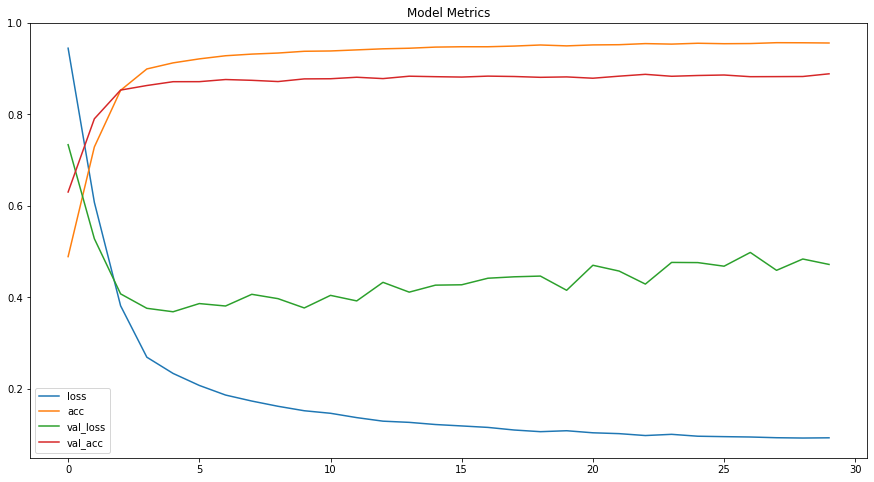

In [46]:
metrics_lstm_1.plot(figsize=(15, 8))
plt.title('Model Metrics')
plt.show()

In [47]:
lstm_pred_train1=model_lstm_1.predict(X_train)
lstm_pred_test1=model_lstm_1.predict(X_test)
lstm_pred_train_lbl1=lstm_pred_train1.argmax(axis=1)
lstm_pred_test_lbl1=lstm_pred_test1.argmax(axis=1)
print(classification_report(y_train, lstm_pred_train_lbl1))
print(classification_report(y_test, lstm_pred_test_lbl1))

382/382 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.99      0.94      0.97     17851
           1       0.97      0.96      0.96     14531
           2       0.92      0.98      0.95     16506

    accuracy                           0.96     48888
   macro avg       0.96      0.96      0.96     48888
weighted avg       0.96      0.96      0.96     48888

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      4502
           1       0.88      0.88      0.88      3574
           2       0.86      0.90      0.88      4147

    accuracy                           0.89     12223
   macro avg       0.89      0.89      0.89     12223
weighted avg       0.89      0.89      0.89     12223



Model LSTM menghasilkan akurasi yang cukup baik yaitu **0.96** pada training set dan **0.89** pada validation set. 

Grafik metric dapat diketahui model mengalami **overfitting** ini ditandai saat training loss dari model turun tetapi validation lossnya naik. 

## GRU Model

### Model Definition

In [48]:
# here n_most_words = 23091(vocab_size)+1
n_most_words = 23092
n_dim = 64
model_gru_1 = Sequential()
model_gru_1.add(Embedding(n_most_words,n_dim,input_length = X_train.shape[1]))
model_gru_1.add(GRU(32))
model_gru_1.add(Dense(3,activation='softmax'))
model_gru_1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
print(model_gru_1.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 40, 64)            1477888   
                                                                 
 gru (GRU)                   (None, 32)                9408      
                                                                 
 dense_1 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,487,395
Trainable params: 1,487,395
Non-trainable params: 0
_________________________________________________________________
None


### Model Training

In [49]:
#train model 
model_gru_1_history = model_gru_1.fit(X_train,y_train_ohe,epochs=30,validation_data=(X_test, y_test_ohe),batch_size = 256, verbose = 0)

### Model Evaluation

In [50]:
# metric evaluation
metrics_gru_1 = pd.DataFrame(model_gru_1_history.history)
metrics_gru_1.tail()

,loss,acc,val_loss,val_acc
25,0.084085,0.962424,0.461390,0.889962
26,0.081201,0.963161,0.488158,0.891516
27,0.080676,0.963427,0.488958,0.893889
28,0.076946,0.965206,0.487997,0.893889
29,0.075673,0.965022,0.493009,0.890616


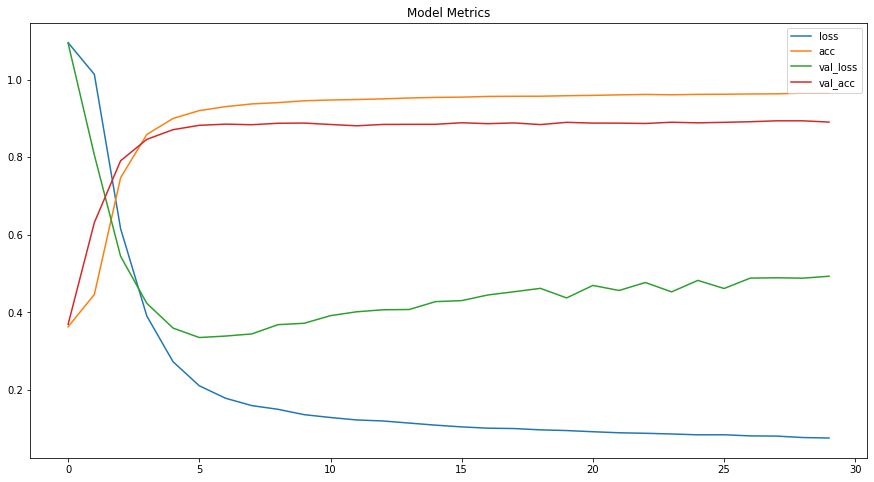

In [51]:
metrics_gru_1.plot(figsize=(15, 8))
plt.title('Model Metrics')
plt.show()

In [52]:
gru_pred_train1=model_gru_1.predict(X_train)
gru_pred_test1=model_gru_1.predict(X_test)
gru_pred_train_lbl1=gru_pred_train1.argmax(axis=1)
gru_pred_test_lbl1=gru_pred_test1.argmax(axis=1)
print(classification_report(y_train, gru_pred_train_lbl1))
print(classification_report(y_test, gru_pred_test_lbl1))

382/382 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.99      0.96      0.97     17851
           1       0.92      0.99      0.96     14531
           2       0.98      0.95      0.97     16506

    accuracy                           0.97     48888
   macro avg       0.96      0.97      0.97     48888
weighted avg       0.97      0.97      0.97     48888

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      4502
           1       0.84      0.92      0.87      3574
           2       0.90      0.88      0.89      4147

    accuracy                           0.89     12223
   macro avg       0.89      0.89      0.89     12223
weighted avg       0.89      0.89      0.89     12223



Model GRU menghasilkan akurasi yang cukup baik yaitu **0.97** pada training set dan **0.89** pada validation set. 

Grafik metric dapat diketahui model mengalami **overfitting** ini ditandai saat training loss dari model turun tetapi validation lossnya naik. 

## Model Comparison

In [53]:
print(classification_report(y_test, lstm_pred_test_lbl1))
print(classification_report(y_test, gru_pred_test_lbl1))

              precision    recall  f1-score   support

           0       0.93      0.88      0.90      4502
           1       0.88      0.88      0.88      3574
           2       0.86      0.90      0.88      4147

    accuracy                           0.89     12223
   macro avg       0.89      0.89      0.89     12223
weighted avg       0.89      0.89      0.89     12223

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      4502
           1       0.84      0.92      0.87      3574
           2       0.90      0.88      0.89      4147

    accuracy                           0.89     12223
   macro avg       0.89      0.89      0.89     12223
weighted avg       0.89      0.89      0.89     12223



Text(570.5454545454544, 0.5, 'Actual')

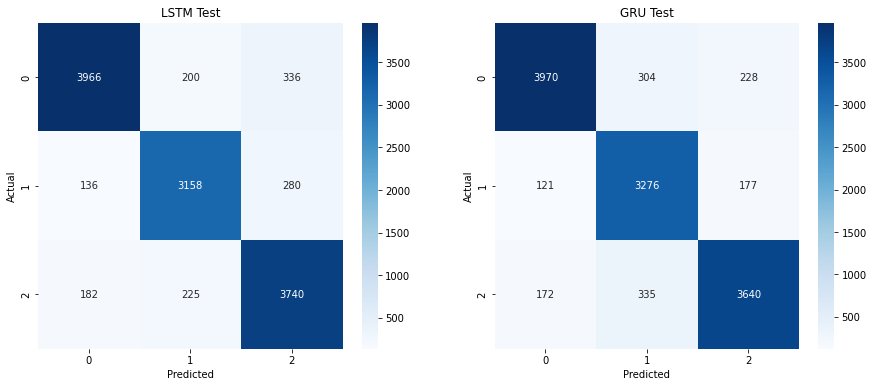

In [54]:
cm1 = math.confusion_matrix(y_test, lstm_pred_test_lbl1)
cm2 = math.confusion_matrix(y_test, gru_pred_test_lbl1)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm1,annot=True,fmt='d',cmap='Blues')
plt.title('LSTM Test')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
sns.heatmap(cm2,annot=True,fmt='d',cmap='Blues')
plt.title('GRU Test')
plt.xlabel('Predicted')
plt.ylabel('Actual')

untuk perbandingan 
- GRU memprediksi label 1 "Netral" lebih baik daripada LSTM
- LSTM memprediksi label 2 "Positive" lebih baik daripada GRU
- Label 0 atau "Negative" lebih unggul GRU daripada LSTM 

Karena Model GRU secara overall lebih baik dari LSTM makan saya akan memakai GRU untuk improved model

## Model Improvement 1 GRU


#### **untuk model improvement saya akan tambahkan early_stop untuk menghindari overfit dan optimizer menggunakan nadam**

In [55]:
#make early stop
early_stop = EarlyStopping(patience=4,restore_best_weights=True,monitor='val_loss')

In [56]:
# here n_most_words = 23091(vocab_size)+1
n_most_words = 23092
n_dim = 64
model_gru_2 = Sequential()
model_gru_2.add(Embedding(n_most_words,n_dim,input_length = X_train.shape[1]))
model_gru_2.add(GRU(32))
model_gru_2.add(Dense(3,activation='softmax'))
model_gru_2.compile(optimizer='nadam', loss='categorical_crossentropy', metrics=['acc'])
print(model_gru_2.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 40, 64)            1477888   
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dense_2 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,487,395
Trainable params: 1,487,395
Non-trainable params: 0
_________________________________________________________________
None


In [57]:
#train improved model 2
model_gru_2_history = model_gru_2.fit(X_train,y_train_ohe,epochs=30,validation_data=(X_test, y_test_ohe),batch_size = 256, callbacks=[early_stop], verbose = 0)

In [58]:
metrics_gru_2 = pd.DataFrame(model_gru_2_history.history)
metrics_gru_2.tail()

,loss,acc,val_loss,val_acc
7,0.162480,0.935424,0.342671,0.884235
8,0.146451,0.941315,0.358792,0.886116
9,0.136613,0.943913,0.369570,0.885871
10,0.129371,0.947370,0.380726,0.886362
11,0.120084,0.950090,0.396705,0.883089


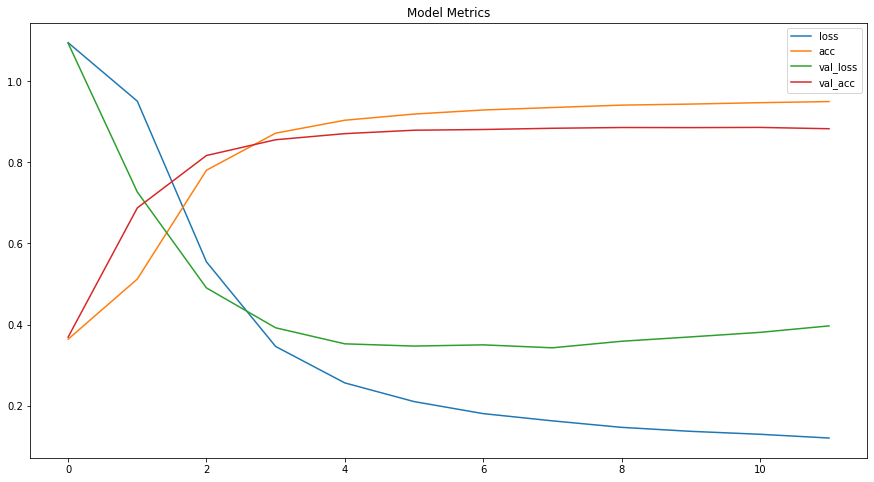

In [59]:
metrics_gru_2.plot(figsize=(15, 8))
plt.title('Model Metrics')
plt.show()

In [60]:
gru_pred_train2=model_gru_2.predict(X_train)
gru_pred_test2=model_gru_2.predict(X_test)
gru_pred_train_lbl2=gru_pred_train2.argmax(axis=1)
gru_pred_test_lbl2=gru_pred_test2.argmax(axis=1)
print(classification_report(y_train, gru_pred_train_lbl2))
print(classification_report(y_test, gru_pred_test_lbl2))

382/382 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.90      0.97      0.94     17851
           1       0.98      0.90      0.94     14531
           2       0.96      0.94      0.95     16506

    accuracy                           0.94     48888
   macro avg       0.95      0.94      0.94     48888
weighted avg       0.94      0.94      0.94     48888

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      4502
           1       0.92      0.83      0.87      3574
           2       0.89      0.89      0.89      4147

    accuracy                           0.88     12223
   macro avg       0.89      0.88      0.88     12223
weighted avg       0.89      0.88      0.88     12223



Model GRU Improved 1 menghasilkan akurasi yang cukup baik yaitu **0.94** pada training set dan **0.88** pada validation set. 
model sudah goodfit, jarak antara akurasi training dan test lebih dekat dibanding base model namun secara akurasi menurun 


## Model Improvement 2 GRU


#### **Menambahkan Drop Out (0.3) dan mengubah optimizer menjadi RMSprop**

In [61]:
# now we create our model
# here n_most_words = 23091(vocab_size)+1
n_most_words = 23092
n_dim = 64
model_gru_3 = Sequential()
model_gru_3.add(Embedding(n_most_words,n_dim,input_length = X_train.shape[1]))
model_gru_3.add(SpatialDropout1D(0.3))
model_gru_3.add(GRU(32))
model_gru_3.add(Dense(3,activation='softmax'))
model_gru_3.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['acc'])
print(model_gru_3.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 40, 64)            1477888   
                                                                 
 spatial_dropout1d (SpatialD  (None, 40, 64)           0         
 ropout1D)                                                       
                                                                 
 gru_2 (GRU)                 (None, 32)                9408      
                                                                 
 dense_3 (Dense)             (None, 3)                 99        
                                                                 
Total params: 1,487,395
Trainable params: 1,487,395
Non-trainable params: 0
_________________________________________________________________
None


In [62]:
model_gru_3_history = model_gru_3.fit(X_train,y_train_ohe,epochs=30,validation_data=(X_test, y_test_ohe),batch_size = 256, callbacks=[early_stop], verbose = 0)

In [63]:
metrics_gru_3 = pd.DataFrame(model_gru_3_history.history)
metrics_gru_3.tail()

,loss,acc,val_loss,val_acc
25,0.135381,0.944792,0.307768,0.897161
26,0.130537,0.946879,0.308808,0.899452
27,0.128720,0.948085,0.308778,0.899943
28,0.125888,0.947922,0.303645,0.901579
29,0.123847,0.949681,0.301004,0.901252


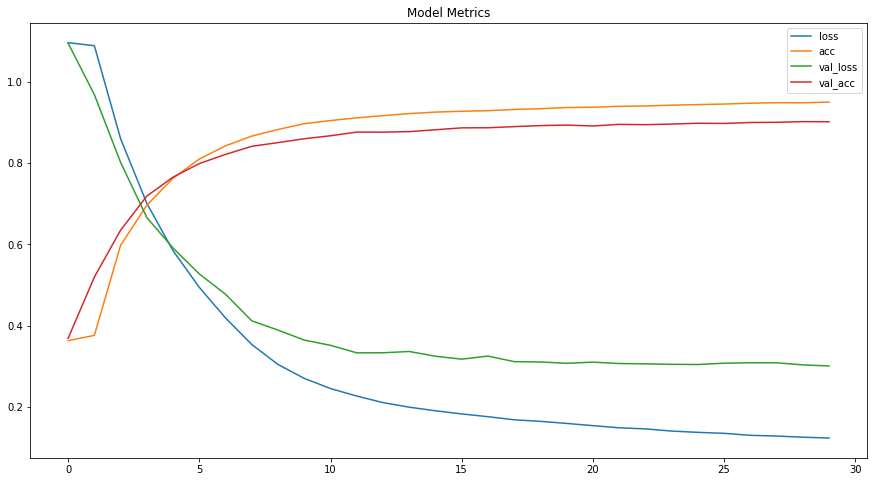

In [64]:
metrics_gru_3.plot(figsize=(15, 8))
plt.title('Model Metrics')
plt.show()

In [65]:
gru_pred_train3=model_gru_3.predict(X_train)
gru_pred_test3=model_gru_3.predict(X_test)
gru_pred_train_lbl3=gru_pred_train3.argmax(axis=1)
gru_pred_test_lbl3=gru_pred_test3.argmax(axis=1)
print(classification_report(y_train, gru_pred_train_lbl3))
print(classification_report(y_test, gru_pred_test_lbl3))

382/382 [==============================] - 2s 4ms/step
              precision    recall  f1-score   support

           0       0.97      0.95      0.96     17851
           1       0.98      0.94      0.96     14531
           2       0.92      0.97      0.95     16506

    accuracy                           0.96     48888
   macro avg       0.96      0.96      0.96     48888
weighted avg       0.96      0.96      0.96     48888

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      4502
           1       0.92      0.87      0.90      3574
           2       0.87      0.93      0.90      4147

    accuracy                           0.90     12223
   macro avg       0.90      0.90      0.90     12223
weighted avg       0.90      0.90      0.90     12223



Model GRU Improved 2 menghasilkan akurasi yang cukup baik yaitu **0.96** pada training set dan **0.90** pada validation set. 

ada peningkatan 1% terhadap validation set dari base model dari 89% menjadi 90%

## Model Improvement 3 GRU


#### **Menambah 2 Hidden Layer dan menambah dimension menjadi 128**

In [66]:
# now we create our model
# here n_most_words = 23091(vocab_size)+1
n_most_words = 23092
n_dim = 128
model_gru_4 = Sequential()
model_gru_4.add(Embedding(n_most_words,n_dim,input_length = X_train.shape[1]))
model_gru_4.add(SpatialDropout1D(0.3))
model_gru_4.add(GRU(64))
model_gru_4.add(Dense(32,activation='relu'))
model_gru_4.add(Dense(16,activation='relu'))
model_gru_4.add(Dense(3,activation='softmax'))
model_gru_4.compile(optimizer='RMSprop', loss='categorical_crossentropy', metrics=['acc'])
print(model_gru_4.summary())

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 40, 128)           2955776   
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 40, 128)          0         
 lDropout1D)                                                     
                                                                 
 gru_3 (GRU)                 (None, 64)                37248     
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 3)                 51        
                                                      

In [67]:
model_gru_4_history = model_gru_4.fit(X_train,y_train_ohe,epochs=30,validation_data=(X_test, y_test_ohe),batch_size = 256, callbacks=[early_stop], verbose = 0)

In [68]:
metrics_gru_4 = pd.DataFrame(model_gru_4_history.history)
metrics_gru_4.tail()

,loss,acc,val_loss,val_acc
23,0.111890,0.953363,0.277943,0.905424
24,0.106481,0.954508,0.289788,0.908615
25,0.103652,0.956104,0.298896,0.907142
26,0.099494,0.957495,0.282371,0.909024
27,0.094928,0.958354,0.290942,0.907470


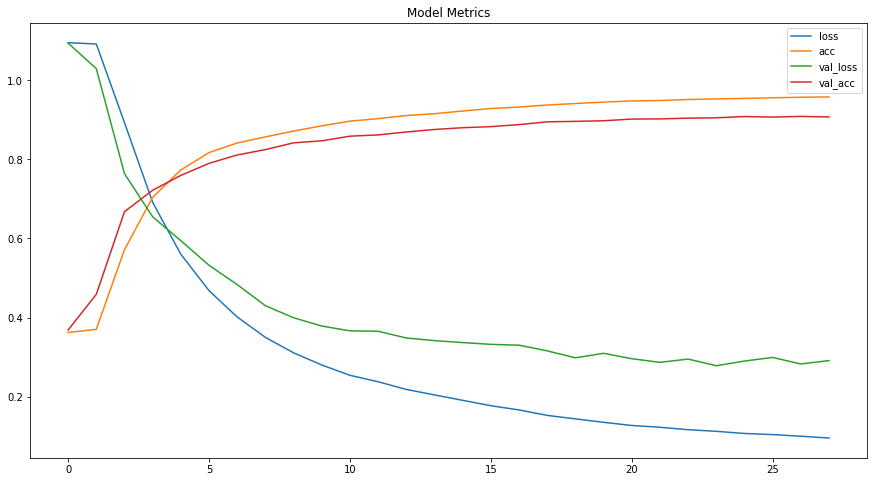

In [69]:
metrics_gru_4.plot(figsize=(15, 8))
plt.title('Model Metrics')
plt.show()

In [70]:
gru_pred_train4=model_gru_4.predict(X_train)
gru_pred_test4=model_gru_4.predict(X_test)
gru_pred_train_lbl4=gru_pred_train4.argmax(axis=1)
gru_pred_test_lbl4=gru_pred_test4.argmax(axis=1)
print(classification_report(y_train, gru_pred_train_lbl4))
print(classification_report(y_test, gru_pred_test_lbl4))

382/382 [==============================] - 2s 5ms/step
              precision    recall  f1-score   support

           0       0.98      0.95      0.97     17851
           1       0.92      0.98      0.95     14531
           2       0.97      0.95      0.96     16506

    accuracy                           0.96     48888
   macro avg       0.96      0.96      0.96     48888
weighted avg       0.96      0.96      0.96     48888

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      4502
           1       0.86      0.92      0.89      3574
           2       0.90      0.91      0.90      4147

    accuracy                           0.91     12223
   macro avg       0.90      0.91      0.90     12223
weighted avg       0.91      0.91      0.91     12223



Model GRU Improved 3 akurasi yang cukup baik yaitu **0.96** pada training set dan **0.91** pada validation set. 

ada peningkatan 2% terhadap validation set dari base model dari 89% menjadi 91% model sudah goodfit karena akurasi training dan validation hanya berbeda 5% 

Karena Model GRU Improved 3 adalah model dengan akurasi paling bagus diantara improved model lainnya maka saya akan memilih Model GRU Improved 3

## Model Comparison 
### Base Model GRU vs Best Improvement Model GRU

In [71]:
print(classification_report(y_test, gru_pred_test_lbl1))
print(classification_report(y_test, gru_pred_test_lbl4))

              precision    recall  f1-score   support

           0       0.93      0.88      0.91      4502
           1       0.84      0.92      0.87      3574
           2       0.90      0.88      0.89      4147

    accuracy                           0.89     12223
   macro avg       0.89      0.89      0.89     12223
weighted avg       0.89      0.89      0.89     12223

              precision    recall  f1-score   support

           0       0.95      0.90      0.92      4502
           1       0.86      0.92      0.89      3574
           2       0.90      0.91      0.90      4147

    accuracy                           0.91     12223
   macro avg       0.90      0.91      0.90     12223
weighted avg       0.91      0.91      0.91     12223



Ada peningkatan 2% terhadap validation set dari base model dari 89% menjadi 91%

Text(570.5454545454544, 0.5, 'Actual')

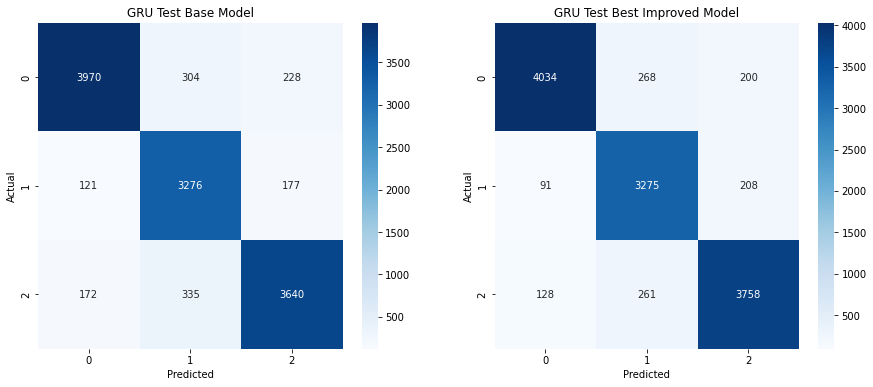

In [72]:
cm3 = math.confusion_matrix(y_test, gru_pred_test_lbl1)
cm4 = math.confusion_matrix(y_test, gru_pred_test_lbl4)

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.heatmap(cm3,annot=True,fmt='d',cmap='Blues')
plt.title('GRU Test Base Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.subplot(1, 2, 2)
sns.heatmap(cm4,annot=True,fmt='d',cmap='Blues')
plt.title('GRU Test Best Improved Model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Dari confusion matrix diatas


- Model GRU Improved 3  berhasil memperbaiki label 0 "Negative" sebanyak 74 

- Model GRU Improved 3  hanya memiliki selisih 1 terhadap base model label "Neutral" lebih unggul base model GRU

- Model GRU Improved 3  berhasil memperbaiki label 2 "Positive" sebanyak 118 

## Model Analysis

Setelah dilakukan peningkatan terhadap model dengan mengubah optimizer menjadi **RMSprop**, menambahkan **1 regularisasi Dropout** dengan **rate = 0.3**, menambahkan **2 hidden layer** , dan menambahkan early_stop, model **tidak lagi mengalami overfitting** dan sudah menjadi model good fit

Secara keseluruhan model sudah baik dan menghasilkan akurasi sebasar **0.96** pada training set dan **0.91** pada validation set.

Ada peningkatan 2% terhadap validation set dari base model dari 89% menjadi 91%

## Model Save

In [73]:
model_gru_4.save('model_gru_improved')

INFO:tensorflow:Assets written to: model_gru_improved\assets


INFO:tensorflow:Assets written to: model_gru_improved\assets


## Model Inference

In [74]:
data_inf['tweet-clean'] = data_inf['tweet'].apply(lambda x: cleaned_review(x))
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data_inf['tweet-clean'].values)
sequences = tokenizer.texts_to_sequences(data_inf['tweet-clean'].values)
word_index = tokenizer.word_index
data_inf_prepro = pad_sequences(sequences, maxlen=max_len, padding='post')


c:\Users\Xyla\AppData\Local\Programs\Python\Python310\lib\site-packages\bs4\__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [75]:
inf_pred = model_gru_4.predict(data_inf_prepro)
inf_pred=inf_pred.argmax(axis=1)
data_inf['predict sentiment']=inf_pred
data_inf['predict sentiment']=data_inf['predict sentiment'].replace({0:'Negative', 1:'Neutral', 2:'Positive'})
data_inf[['tweet','sentiment','predict sentiment']]


1/1 [==============================] - 0s 31ms/step


,tweet,sentiment,predict sentiment
0,"I used to love Black Ops, but after Modern War...",Negative,Positive
1,But they will vigorously defend their product ...,Negative,Negative
2,it Fucks wit it,Negative,Neutral
3,Amazon Online – Cherry Natural Tea Chunky Sals...,Neutral,Positive
4,How the very hell don't you decipher between a...,Negative,Negative
5,"But By sometimes forcing Bing on Chrome users,...",Neutral,Negative
6,I would get genuinely upset,Negative,Neutral
7,Join me Neil Neale for my SUPERJAM XTRA SHOW!....,Neutral,Positive
8,That's cool. 19. November for the rest of the ...,Positive,Negative
9,I miss Facebook so much a unblockkkk gets me o...,Positive,Positive


Model Inference berhasil memprediksi 30% dari total data inference

Data seperti apa yang akan diprediksi salah oleh model ?

contoh pada tweet no 1 

- "I used to love BlackOps" love merupakan kata sentiment positive namun, karena keseluruhan kata bermakna lampau yang artinya sudah tidak menyukai alhasil model salah memprediksi tweet tersebut

Secara keseluruhan 10 data inference bukan lah suatu kesimpulan secara keseluruhan karena hanya menggunakan sedikit data. 

## Pengambilan Kesimpulan



### EDA Analysis

Sentiment vs Entity
- Game Action seperti dan Open World memiliki sentiment positive
- Company seperti Facebook, Amazom memiliki sentiment netral
- Game Sport seperti NBA, FIFA, Madden NFL memilii sentiment negative

Sentiment vs Jumlah kata
- Sentiment positive relatif memiliki kata yang sedikit
- Sentiment negative relatif memiliki kata yang panjang karena berupa kritik
- Sentiment Netral ada di tengah tengah antara negative dan positive

Kata positive adalah : Love, Like, Good, Best

Kata Neutral didominasi oleh company seperti : Facebook,Amazon,Johnson and Johnson

Kata Negative adalah : Fuck, Shit, Game(karena majority entity gam seperti sport ada di sentiment negative)

### Overall Analysis	

### Penjelasan Arsitektur improved

Setelah dilakukan peningkatan terhadap model dengan mengubah optimizer menjadi **RMSprop**, menambahkan **1 regularisasi Dropout** dengan **rate = 0.3**, menambahkan **2 hidden layer** , dan menambahkan early_stop, model **tidak lagi mengalami overfitting** dan sudah menjadi model good fit

Secara keseluruhan model sudah baik dan menghasilkan akurasi sebasar **0.96** pada training set dan **0.91** pada validation set.

Ada peningkatan 2% terhadap validation set dari base model dari 89% menjadi 91%

## Apa yang menyebabkan Model Salah Memprediksi

Salah satu faktor kenapa model tidak bisa memprediksi sebuah tweet adalah 

karena ada kata negative dan positive dalam satu tweet yang menyebabkan model salah memprediksi

Model hanya bisa menebak bedasarkan kata, bukan konteks 

Contoh

- "I Fucking Love this game" Model memprediksi negative karena ada 2 kata negative sedangkan makna sebenarnya adalah Positive yang menyatakan bahwa dia sangat suka game tersebut

Contoh lain yang seperti di model inference,

- "I used to love BlackOps" love merupakan kata sentiment positive namun, karena keseluruhan kata bermakna lampau yang artinya sudah tidak menyukai alhasil model salah memprediksi tweet tersebut


## Apa maksud dari performansi yang didapatkan baik saat training maupun testing ?

Performansi yang baik adalah ketika hasil akurasi Training Set dan Validation Set memiliki selisih yang rendah, dan bisa dikatakan GoodFit